In [1]:
import pandas as pd
import os
import numpy as np
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch as th

import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from skimage.io import imread
from torch.utils import data
from tqdm import tqdm

import glob
import re

import time

In [2]:
class CombineDataset_1(Dataset):

    def __init__(self, frame, id_col, label_name, path_imgs, is_valid):
        
        self.frame = frame
        self.id_col = id_col
        self.label_name = label_name
        self.path_imgs = path_imgs
        self.is_valid = is_valid
        
        if self.is_valid == 1:
            self.aug = transforms.Compose([
                    transforms.Resize((img_size)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(degrees=60),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                    ])
        else:
            self.aug = transforms.Compose([
                    transforms.Resize((img_size)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                    ])
            
            

    def __len__(self):
        return (self.frame.shape[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.frame[self.id_col].iloc[idx]
        img = os.path.join (self.path_imgs, img_name +'.jpg')

        image1 = Image.open(img)
        image = self.aug(image1)

        feats = [feat for feat in self.frame.columns if feat not in [self.label_name,self.id_col]]
        feats  = np.array(self.frame[feats].iloc[idx])
        feats = feats.tolist()
        feats = torch.FloatTensor(feats)

        label = np.array(self.frame[self.label_name].iloc[idx])
        label = torch.tensor(label, dtype=torch.long)
        
        name = self.frame[self.id_col].iloc[idx]

        return image, feats, label, name
    
class CombineDataset(Dataset):

    def __init__(self, frame, id_col, label_name, path_imgs, use_cache = False, transform = None):
        
        self.frame = frame
        self.id_col = id_col
        self.label_name = label_name
        self.path_imgs = path_imgs
        self.inputs_dtype = torch.float32
        
        self.transform = transform
        
        self.use_cache = use_cache
        
        if self.use_cache:
            self.cached_data = []

            progressbar = tqdm(range(len(self.path_imgs)), desc='Caching')
            
            for i, img in zip(progressbar, self.path_imgs):
                img = Image.open(img)
                if self.transform is not None:
                    img= self.transform(img)
                
                self.cached_data.append(img)
            

    def __len__(self):
        return (self.frame.shape[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img = self.cached_data[idx]

        feats = [feat for feat in self.frame.columns if feat not in [self.label_name,self.id_col]]
        feats  = np.array(self.frame[feats].iloc[idx])
        feats = feats.tolist()
        feats = torch.FloatTensor(feats)

        label = np.array(self.frame[self.label_name].iloc[idx])
        label = torch.tensor(label, dtype=torch.long)
        
        name = self.frame[self.id_col].iloc[idx]

        return img, feats, label, name
    
    
def get_default_device():
    if torch.cuda.is_available():
        
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [3]:
class Sampler(object):
    def __init__(self, data_source):
        pass
    
    def __iter__(self):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError
        
class StratifiedSampler(Sampler):
    
    def __init__(self, class_vector, y):
        self.n_splits = 1
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
             print('Error')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        X = th.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index= next(s.split(X, y))
        return train_index, test_index

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)

In [4]:
def estimate_weights_mfb(label):
    class_weights = np.zeros_like(label, dtype=np.float)
    counts = np.zeros_like(label)
    for i,l in enumerate(label):
        dir_path = os.path.join(data_dir,l)
        counts[i] = len(os.listdir(dir_path))
    counts = counts.astype(np.float)
    median_freq = np.median(counts)
    
    for i, label in enumerate(label):
        class_weights[i] = median_freq / counts[i]
    return class_weights

In [5]:
data_dir = "C:\\Users\\...\\DATASET\\"
metadata = pd.read_csv('C:\\Users\\...\\MetaData.csv')

numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

data_dir2 = sorted(glob.glob('C:\\Users\\...\\DATASET\\*.jpg'), key=numericalSort)

labels = ['vascular lesions', 'nevus', 'solar lentigo', 'dermatofibroma', 'seborrheic ketarosis', 'benign ketarosis', 'actinic keratosis', 'basal cell carcinoma', 'squamous cell carcinoma', 'melanoma']
labels2 = ['0. vascular lesions', '1. nevus', '2. solar lentigo', '3. dermatofibroma', '4. seborrheic ketarosis', '5. benign ketarosis', '6. actinic keratosis', '7. basal cell carcinoma', '8. squamous cell carcinoma', '9. melanoma']

img_size = 229, 229
batch_size = 8
num_classes = 10
num_epochs = 7

device = get_default_device()

In [ ]:
metadata_age = metadata[['age']]
Age_grup = []

for i in metadata_age['age']:
    if i <= 44:
        Age_grup += ['young']
    elif 45 <= i <= 59:
        Age_grup += ['middle']
    elif 60 <= i <= 74:
        Age_grup += ['elderly']
    elif 75 <= i:
        Age_grup += ['senile']
    else:
        Age_grup += ['error']
        
metadata['age'] = Age_grup

In [ ]:
encode_map_categor = {'0. vascular lesions': 0, '1. nevus': 1, '2. solar lentigo': 2, '3. dermatofibroma': 3, '4. seborrheic keratosis': 4, '5. benign ketarosis': 5, '6. actinic keratosis': 6, '7. basal cell carcinoma': 7, '8. squamous cell carcinoma': 8, '9. melanoma': 9}

encode_map_age = {'young': 0, 'middle': 1, 'elderly': 2, 'senile': 3}
encode_map_sex = {'male': 0, 'female': 1}
encode_map_anatomloc = {'anterior torso': 0, 'head/neck': 1, 'lateral torso': 2, 'lower extremity': 3, 'oral/genital': 4, 'palms/soles': 5, 'posterior torso': 6, 'upper extremity': 7}

metadata['diagnosis'].replace(encode_map_categor, inplace=True)
metadata['age'].replace(encode_map_age, inplace=True)
metadata['sex'].replace(encode_map_sex, inplace=True)
metadata['anatomloc'].replace(encode_map_anatomloc, inplace=True)

In [6]:
label_images = []
le = OneHotEncoder()

label_encoded1 = le.fit_transform(metadata['diagnosis'].astype(str))
metadata['diagnosis'] = label_encoded1

label_encoded2 = le.fit_transform(metadata['age'].astype(str))
metadata['age'] = label_encoded2

label_encoded3 = le.fit_transform(metadata['sex'].astype(str))
metadata['sex'] = label_encoded3

label_encoded4 = le.fit_transform(metadata['anatomloc'].astype(str))
metadata['anatomloc'] = label_encoded4

In [ ]:
test_size = 0.2
val_size = 0.25

data_label = metadata['diagnosis'].to_numpy()

ss = StratifiedSampler(torch.FloatTensor(data_label), test_size)
pre_train_indices, test_indices = ss.gen_sample_array()

train_label = np.delete(data_label, test_indices, None)
ss = StratifiedSampler(torch.FloatTensor(train_label), test_size)
train_indices, val_indices = ss.gen_sample_array()

indices = {'train': pre_train_indices[train_indices],
           'val': pre_train_indices[val_indices],
           'test': test_indices}

train_indices = indices['train']
val_indices = indices['val']
test_indices = indices['test']

In [8]:
mm_weight = estimate_weights_mfb(labels2)
mm_weight = torch.FloatTensor(mm_weight).to(device)

for i in range(len(labels2)):
    print(labels2[i],":", mm_weight[i])

C:\Users\uljah\AppData\Local\Temp\ipykernel_2432\3191655818.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  class_weights = np.zeros_like(label, dtype=np.float)
C:\Users\uljah\AppData\Local\Temp\ipykernel_2432\3191655818.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = counts.astype(np.float)


0. vascular lesions : tensor(3.8893, device='cuda:0')
1. nevus : tensor(0.0353, device='cuda:0')
2. solar lentigo : tensor(3.6444, device='cuda:0')
3. dermatofibroma : tensor(4., device='cuda:0')
4. seborrheic ketarosis : tensor(0.6721, device='cuda:0')
5. benign ketarosis : tensor(0.8954, device='cuda:0')
6. actinic keratosis : tensor(1.1323, device='cuda:0')
7. basal cell carcinoma : tensor(0.2900, device='cuda:0')
8. squamous cell carcinoma : tensor(1.5000, device='cuda:0')
9. melanoma : tensor(0.1758, device='cuda:0')


In [10]:
train_set = CombineDataset(metadata,'name','diagnosis',data_dir, is_valid = 1)
valid_set = CombineDataset(metadata,'name','diagnosis',data_dir, is_valid = 0)
test_set = CombineDataset(metadata,'name','diagnosis',data_dir, is_valid = 0)

Caching: 100%|██████████████████████████████████████████████████████████████████| 41725/41725 [04:21<00:00, 159.44it/s]


In [11]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = False,  sampler = train_indices)
validatloader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = False,  sampler = val_indices)

testloader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False,  sampler = test_indices)

In [12]:
import timm

inception_v4 = timm.create_model('inception_v4', pretrained=True)
inception_v4.last_linear = nn.Linear(in_features=1536, out_features=num_classes)

class inception(nn.Module):
    def __init__(self):
        super(inception, self).__init__()
        
        self.model = inception_v4
        
        self.meta_net = nn.Sequential(nn.Linear(3, 64),
                                      nn.ReLU(),
                                      nn.BatchNorm1d(64),
                                      nn.Linear(64, 32),
                                      nn.ReLU(),
                                      nn.BatchNorm1d(32),
                                      nn.Linear(32, 32),
                                      nn.ReLU(),
                                      nn.BatchNorm1d(32),
                                      nn.Linear(32, 10))
        
        self.out = nn.Linear(10+10, 10)
                
    def forward(self, img , tab):
        
        img = self.model(img) 
        img = img.reshape(img.shape[0], -1)
        
        tab = self.meta_net(tab)
        
        x = torch.cat((img, tab),1)
        x = self.out(x)
        
        return x


model = inception()
model = model.to(device)

In [ ]:
def train(num_epochs):
    
    MultimodalNN.train()
    train_accuracy = 0
    total = 0
    correct = 0
    acc = 0
    
    for i, data in enumerate(trainloader):
        image, feats, label, name = data
        image, feats, label = image.to(device), feats.to(device), label.to(device)
        
        optimizer.zero_grad()
        
        output = MultimodalNN(image, feats)
            
        loss = criterion(output, label)
            
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        
        train_accuracy = 100 * correct / total
        
        if i % 800 == 0:

            print('Тренировочная эпоха: {} [{}/{} ({:.0f}%)]\t\t | Ошибка: {:.4f}\t | Точность распознавания: {:.2f}%'.format(num_epochs, batch_size * i, len(train_indices), 100 * i / len(trainloader), loss.item(), train_accuracy))
                            
            train_losses_SGD.append(loss.item())
            train_counter_SGD.append((i*batch_size) + ((num_epochs-1)*len(train_indices)))
            train_acc_SGD.append(train_accuracy)
            
def valid():
    
    MultimodalNN.eval()
    
    valid_loss = 0
    correct = 0
    valid_accuracy = 0
    
    with torch.no_grad():
    
        for data in validatloader:
            image, feats, label, name = data
            image, feats, label = image.to(device), feats.to(device), label.to(device)
            
            output = MultimodalNN(image, feats)
            
            valid_loss = criterion(output, label).item()
            
            pred = torch.max(torch.exp(output), 1)[1]
                       
            correct += pred.eq(label.data.view_as(pred)).sum()
    
    print('\nИстинные значения:\t {}'.format(label))
    print('Предсказанные значения:\t {}'.format(pred))

    valid_accuracy = 100 * correct / len(valid_indices)
    valid_accuracy = test_accuracy.cpu()
        
    print ('\nТестовые изображения. Ошибка: {:.4f}\t | Точность распознавания: {}/{} ({:.2f}%)'.format(valid_loss, correct, len(valid_indices), valid_accuracy))
    
    valid_acc_SGD.append(valid_accuracy)
    valid_losses_SGD.append(valid_loss)

In [15]:
criterion = nn.CrossEntropyLoss(weight=mm_weight)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_losses_SGD = []
train_counter_SGD = []
train_acc_SGD = []

valid_losses_SGD = []
valid_counter_SGD = [i*len(train_indices) for i in range(num_epochs + 1)]
valid_acc_SGD = []

In [ ]:
start_time_glob = time.time()

start_time_valid = time.time()
valid()
time_valid = time.time()-start_time_valid
print ('\nВремя тестирования: {}\n'.format(time.strftime("%H:%M:%S", time.gmtime(time_test))))

for num_epochs in range(1, num_epochs + 1):
    
    start_time_tarin = time.time()
    train(num_epochs)
    time_tarin = time.time()-start_time_tarin
    print ('\nВремя обучения за эпоху: {}'.format(time.strftime("%H:%M:%S", time.gmtime(time_tarin))))
    
    start_time_valid = time.time()
    valid()
    time_valid = time.time()-start_time_valid
    print ('\nВремя тестирования: {}\n'.format(time.strftime("%H:%M:%S", time.gmtime(time_test))))

time_glob = time.time()-start_time_glob
print ('\nОбщее время обучения: {}'.format(time.strftime("%H:%M:%S", time.gmtime(time_glob))))

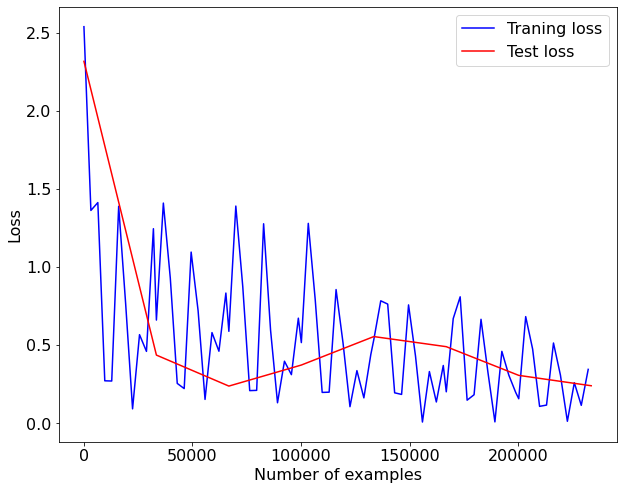

<Figure size 432x288 with 0 Axes>

In [19]:
plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = '16'
plt.plot(train_counter_SGD, train_losses_SGD, color='blue')
plt.plot(valid_counter_SGD, valid_losses_SGD, color='red')
plt.legend(['Traning loss', 'Test loss'], loc='upper right')
plt.xlabel('Number of examples')
plt.ylabel('Loss')
fig = plt.figure()

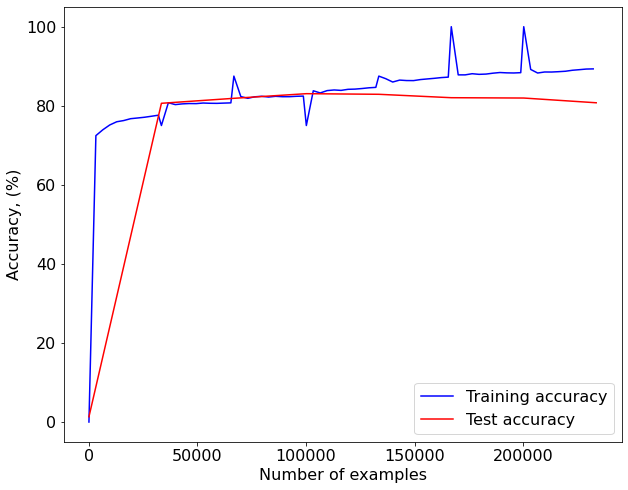

<Figure size 432x288 with 0 Axes>

In [20]:
plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = '16'
plt.plot(train_counter_SGD, train_acc_SGD, color='blue')
plt.plot(valid_counter_SGD, valid_acc_SGD, color='red')
plt.legend(['Training accuracy', 'Test accuracy'], loc='lower right')
plt.xlabel('Number of examples')
plt.ylabel('Accuracy, (%)')
fig = plt.figure()